# Customer Churn Prediction using XGBoost
As a company, it is important to retain our customer, hence knowing which customers is likely to churn will be beneficial as the company can act quickly to prevent it. Churn prediction is predicting which customers are at high risk of leaving your company or canceling a subscription to a service, based on their behavior with your product. In this notebook a prediction of whether a telco customer will churn or stay will be performed using XGBoost model. The data used in this notebook is sourced from <a href="https://www.kaggle.com/datasets/blastchar/telco-customer-churn">here</a>. <br><br>
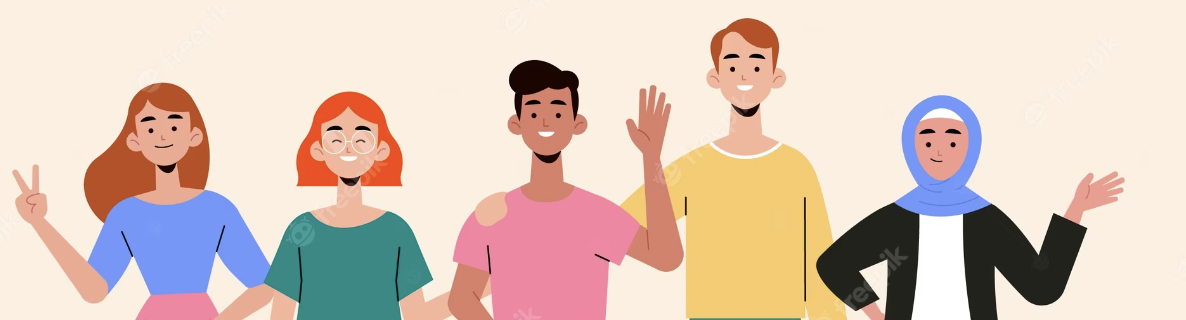

## 1. Libraries and Function

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split

sns.set_style("white")
pd.set_option('display.max_columns', 9999)
global_palette = ["#020659","#ED1C24","#F4C47F","#D38D28"]

In [2]:
def barplot(col, axi, hue = None):
    if hue == None:
        plot_data = data.groupby(col).count()[["customerID"]]
        bar_index = plot_data.index
        return sns.barplot(data=plot_data, x=bar_index, y="customerID", palette=global_palette, ax=axi, hue=None)
    else:
        plot_data = data.groupby([col,hue]).count()[["customerID"]].reset_index()
        bar_index = plot_data[col]
        return sns.barplot(data=plot_data, x=bar_index, y="customerID", palette=global_palette, ax=axi, hue=hue)

## 2. Dataset
This dataset consists of 21 columns with variety of data types. Let's preview our dataset.

In [3]:
data = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


There are some columns that have incorrect data types. Column senior citizen should be string and column TotalCharges should be float. 

In [5]:
data["TotalCharges"][data["TotalCharges"] == " "] = data.MonthlyCharges
data["TotalCharges"] = data.TotalCharges.astype("float64")
data["SeniorCitizen"] = data["SeniorCitizen"].astype("str")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Check the data types fixing. 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 3. Exploratory Data Analysis
In this part, EDA will be performed to see the unique value, distribution, and count of each columns related to customerID. 

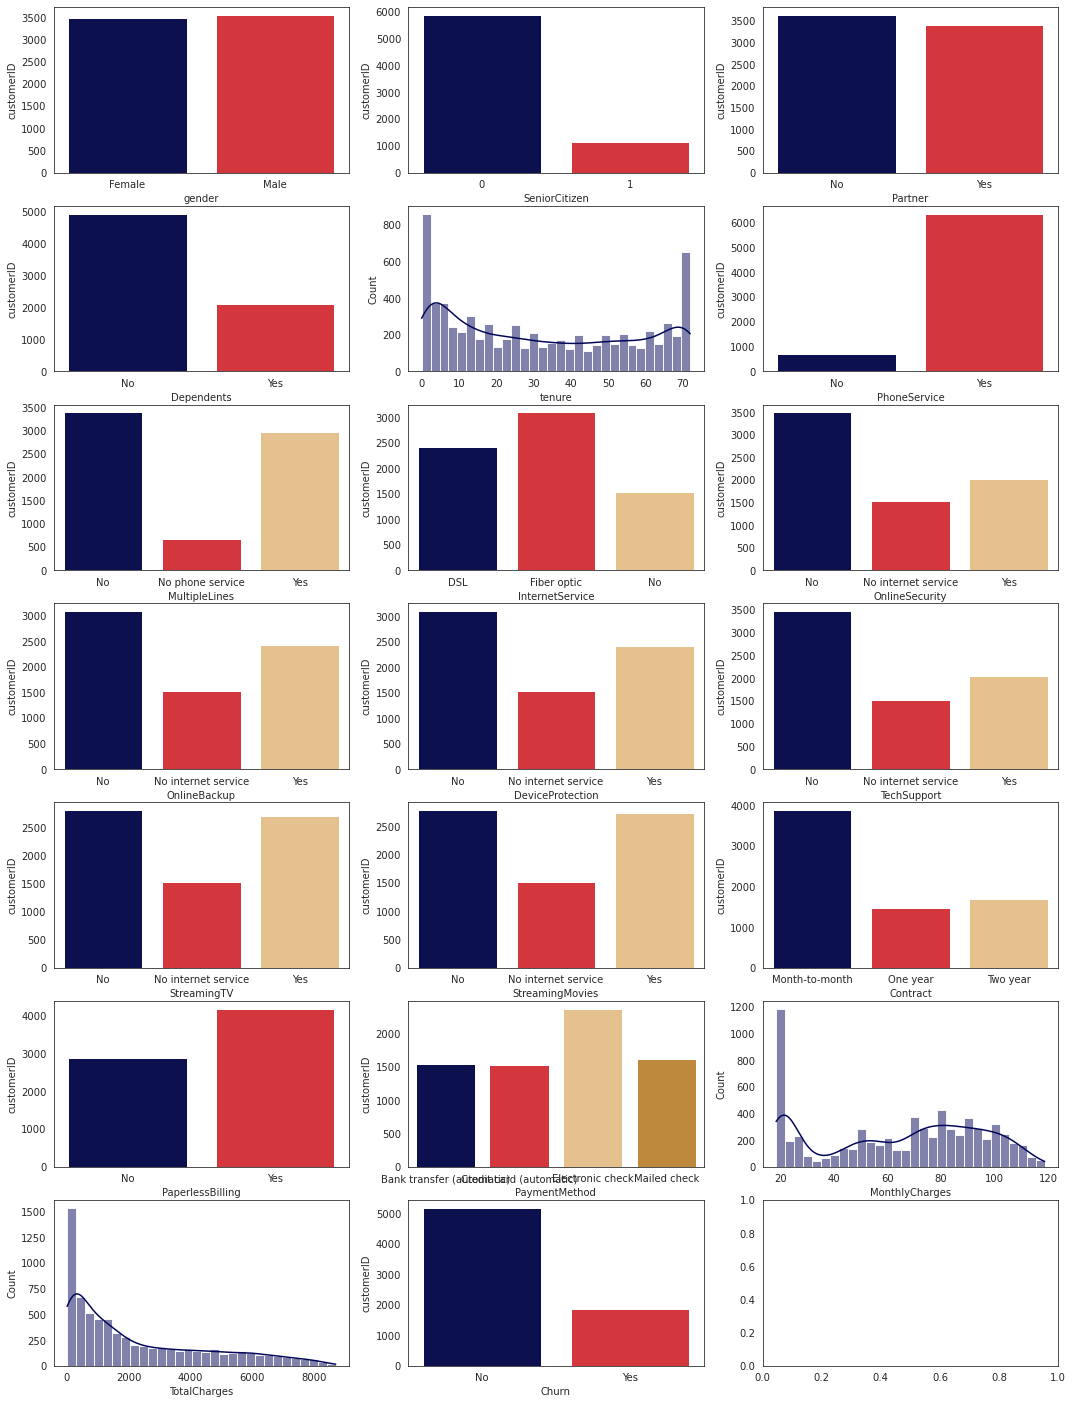

In [7]:
fig, ax = plt.subplots(7,3,figsize=(18,25))
colist = data.drop("customerID",axis=1).columns
colnum = 0
for row in range(7):
    try:
        for col in range(3):
            if data[[colist[colnum]]].dtypes[colist[colnum]] == "O" :
                barplot(colist[colnum],ax[row,col])
            else :
                sns.histplot(data[colist[colnum]], color=global_palette[0], ax=ax[row,col], bins=30, kde=True)
            colnum = colnum + 1
    except:
        pass
plt.show()

As we can see, the count of male and female is roughly the same, and there are more non senior citizen than senior citizen, and the distribution of tenure has two peaks that is likely a bimodal distribution. The other insight could be seen in the figure above. After we know the univariate distribution, let's breakdown each distribution with the label (Churn / Retain)

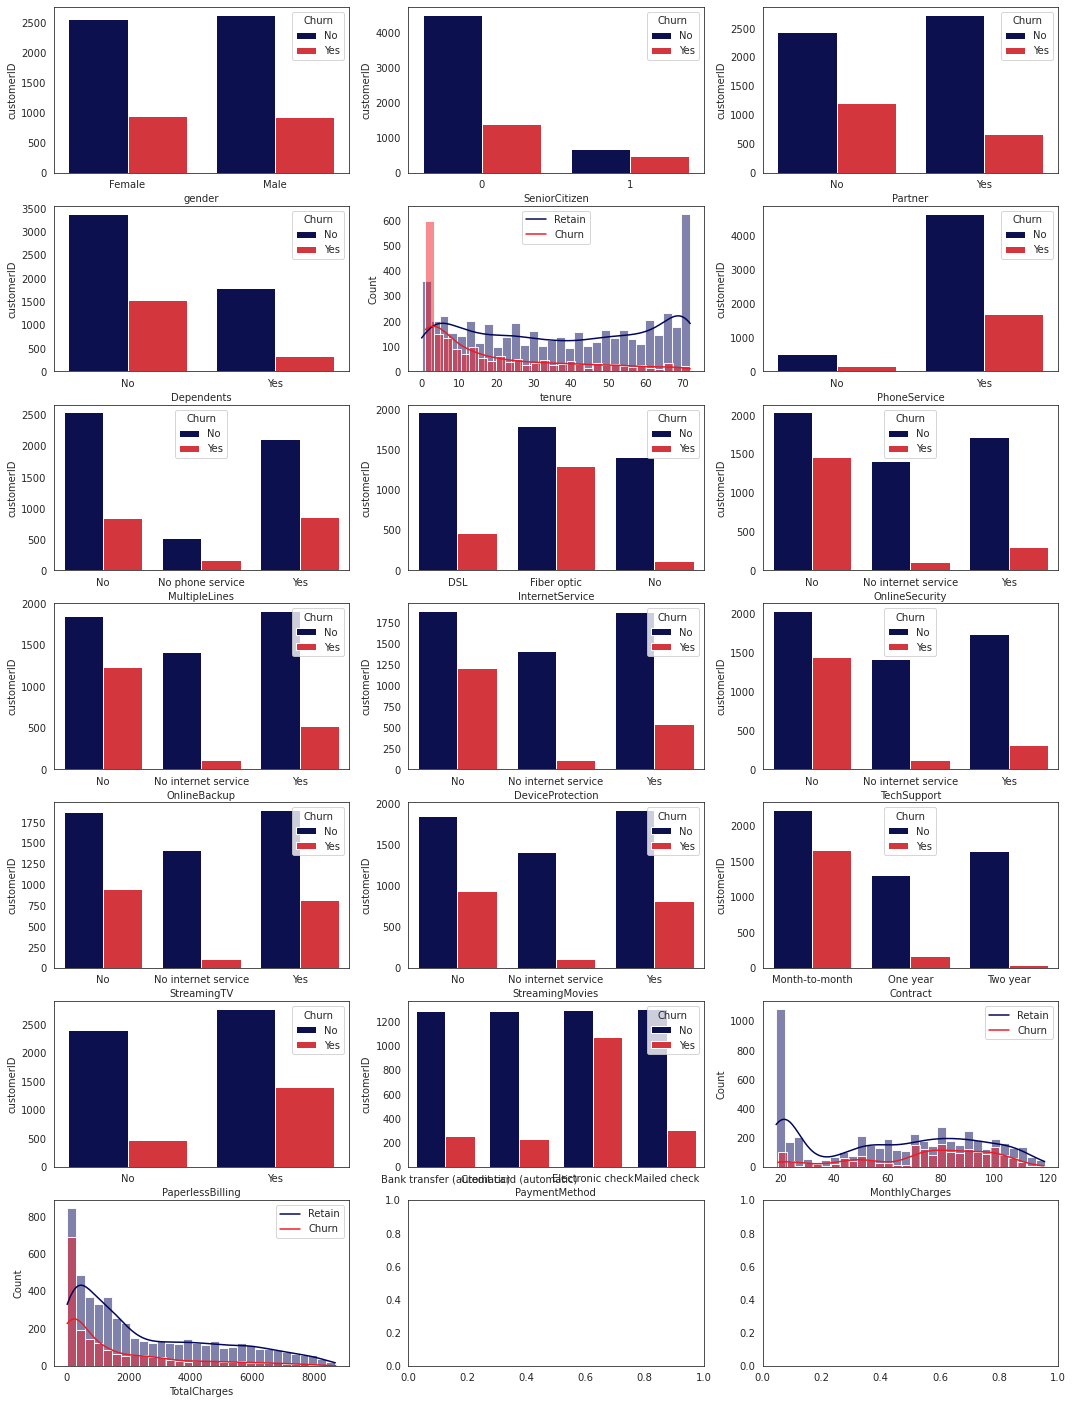

In [8]:
fig, ax = plt.subplots(7,3,figsize=(18,25))
colist = data.drop("customerID",axis=1).columns
colnum = 0
for row in range(7):
    for col in range(3):
        try:
            if data[[colist[colnum]]].dtypes[colist[colnum]] == "O" :
                barplot(colist[colnum],ax[row,col],"Churn")
            else :
                sns.histplot(data[data.Churn == "No"][colist[colnum]], color=global_palette[0], ax=ax[row,col], bins=30, kde=True)
                sns.histplot(data[colist[colnum]][data.Churn == "Yes"], color=global_palette[1], ax=ax[row,col], bins=30, kde=True)
                ax[row,col].legend(["Retain","Churn"])
            colnum = colnum + 1
        except:
            pass
        
plt.show()

Here we can see the distribution of churn or retain for each features. Some insights could be taken from this plot : 
- churn rate in gender feature is roughly the same 
- Other categorical features show different rates of churn for each sub categorical value 
- The distribution of Churn and Retain for Monthly Charges and Total Charges are roughly the same
- The distribution of Churn and Retain for tenure is in reverse

## 4. Dataset Preparation
Now let's prepare our dataset for the model. Here one hot encoding was performed to transform the categorical data. Some column types adjustment also made to fit the model's requirement. 

In [9]:
dataset = data[["Churn"]].copy()
for col in data.drop(["Churn","customerID"],axis=1).columns:
    dataset = pd.concat([dataset,pd.get_dummies(data[[col]])],axis=1)
dataset["Churn"][dataset.Churn == "No"] = 0
dataset["Churn"][dataset.Churn == "Yes"] = 1
for col in dataset.columns:
    try:
        dataset[col] = dataset[col].astype("float")
    except:
        pass
dataset.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,tenure,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.85,29.85
1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,34.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,56.95,1889.50
2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,53.85,108.15
3,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,45.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,42.30,1840.75
4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,70.70,151.65


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Churn                                    7043 non-null   float64
 1   gender_Female                            7043 non-null   float64
 2   gender_Male                              7043 non-null   float64
 3   SeniorCitizen_0                          7043 non-null   float64
 4   SeniorCitizen_1                          7043 non-null   float64
 5   Partner_No                               7043 non-null   float64
 6   Partner_Yes                              7043 non-null   float64
 7   Dependents_No                            7043 non-null   float64
 8   Dependents_Yes                           7043 non-null   float64
 9   tenure                                   7043 non-null   float64
 10  PhoneService_No                          7043 no

Check the dataset label

In [11]:
data.groupby("Churn").count()[["customerID"]]

,customerID
Churn,
No,5174
Yes,1869


We can see that there is a clas imbalance. Now undersampling or oversampling will not be performed here. Instead, we will just leave it like that and use appropriate metrics to measure the performance. These metrics are recall and precision. Please note that in the business context (Churn case), recall metrics is more important. 

After one hot encoding was performed, dataset train and test splitting is underway. 

In [12]:
X = dataset.drop("Churn",axis=1)
y = dataset[["Churn"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

## 5. Model Fitting

The prepared dataset will be fetched to the model for training and testing purpose.

In [13]:
# fit model 
model = XGBClassifier()
model.fit(X_train, y_train)

# make predictions 
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

y_test["predicted"] = y_pred
y_test["predicted_proba"] = y_pred_proba[:,1]
y_test.head()

,Churn,predicted,predicted_proba
2905,0.0,0,0.147417
6651,0.0,0,0.027337
5321,0.0,0,0.091800
4293,1.0,1,0.863030
5686,1.0,1,0.708705


## 6. Evaluation

After the model was trained and tested, we want to measure the performance of our model. Here we will plot the confusion matrix, AUC, proba disribution, and feature importance from the model. 

In [14]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = model.feature_names_in_
feature_importance["value"] = model.feature_importances_
feature_importance = feature_importance.sort_values("value", ascending=False).reset_index(drop=True)
# feature_importance

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


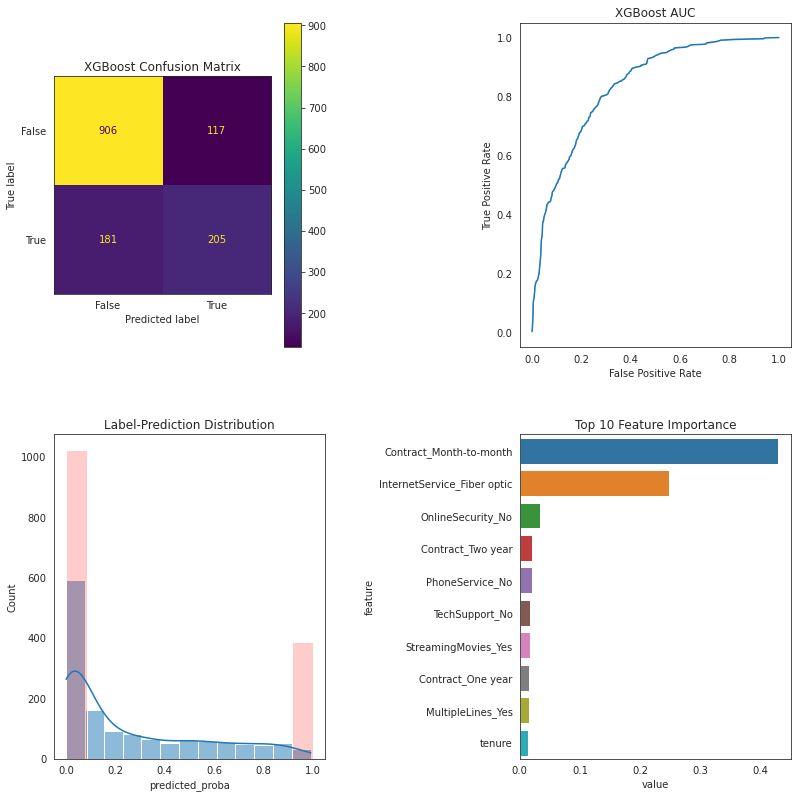

In [15]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
confusion_matrix = metrics.confusion_matrix(y_test.Churn, y_test.predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(ax=ax[0,0])
ax[0,0].set_title("XGBoost Confusion Matrix")

fpr, tpr, _ = metrics.roc_curve(y_test.Churn, y_test.predicted_proba)
sns.lineplot(fpr,tpr,ax=ax[0,1])
ax[0,1].set_xlabel('False Positive Rate')
ax[0,1].set_ylabel('True Positive Rate')
ax[0,1].set_title("XGBoost AUC")

sns.histplot(y_test.predicted_proba,kde=True,ax=ax[1,0])
sns.histplot(y_test.Churn,kde=False,ax=ax[1,0], color="red",alpha=0.2)
ax[1,0].set_title("Label-Prediction Distribution")

sns.barplot(data=feature_importance.iloc[0:10],x="value",y="feature",ax=ax[1,1])
ax[1,1].set_title("Top 10 Feature Importance")

fig.tight_layout(pad=4.0)
plt.show()

Precision and Recall metrics are also need to be checked. 

In [16]:
recallscore = recall_score(y_test.Churn, y_test.predicted, average="binary")
precisionscore = precision_score(y_test.Churn, y_test.predicted, average="binary")
print("XGBoost Recall Score : ",recallscore)
print("XGBoost Precision Score : ",precisionscore)

XGBoost Recall Score :  0.5310880829015544
XGBoost Precision Score :  0.6366459627329193


As we can see the performance of the model is not good enough yet acceptable. There are some things that we can do to improve the model's performance such as hyperparameter tuning, data sampling, and finding the best AUC threshold.

### Reference
- https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
- https://datascience.stackexchange.com/questions/60950/is-it-necessary-to-normalize-data-for-xgboost
- https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
- https://mode.com/blog/predicting-and-preventing-churn/
